In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
import matplotlib.patches as patches
import matplotlib

matplotlib.rcParams['font.family'] = ['serif']
matplotlib.rcParams['font.size'] = 14

In [2]:
# I kind of plot the x-z plane. Therefore, I name it so.
nx = 1024
nz = nx * 1

dx = 1  # mm
dz = 1  # mm

# Define the coordinate system and the position of the crossing
x_c = - nx * dx / 2 * 0.5
z_c = nz * dz / 2 * 0.2

# ---------------------------------------------------------
#     Coordinate system
# ---------------------------------------------------------
x_coor = np.linspace(start=-nx * dx / 2, stop=nx * dx / 2, num=nx) - x_c
z_coor = np.linspace(start=-nz * dz / 2, stop=nz * dz / 2, num=nz) - z_c

xz_coor = np.zeros((nx, nz, 2), dtype=np.float64)
xz_coor[:, :, 0] = x_coor[:, np.newaxis]
xz_coor[:, :, 1] = z_coor[np.newaxis, :]

# ---------------------------------------------------------
#     Complex pulse
# ---------------------------------------------------------
# Define the raw pulse without attenuation
tg_angle = np.deg2rad(8)
tg_pulse_sigma = 30  # mm 

pulse1_dir1 = np.array([-np.sin(tg_angle), np.cos(tg_angle)])
pulse1_dir2 = np.array([pulse1_dir1[1], -pulse1_dir1[0]])
pulse2_dir1 = np.array([np.sin(tg_angle), np.cos(tg_angle)])
pulse2_dir2 = np.array([pulse2_dir1[1], -pulse2_dir1[0]])

pulse1 = np.exp(- 0.5 / tg_pulse_sigma ** 2 * np.dot(xz_coor, pulse1_dir2) ** 2) * np.exp(
    1.j * np.dot(xz_coor, pulse1_dir1) * 1.5)
pulse2 = np.exp(- 0.5 / tg_pulse_sigma ** 2 * np.dot(xz_coor, pulse2_dir2) ** 2) * np.exp(
    1.j * np.dot(xz_coor, pulse2_dir1) * 1.5)

probe_angle = np.deg2rad(20)
probe_sigma = 30  # mm
pulse3_dir1 = np.array([-np.sin(probe_angle), np.cos(probe_angle)])
pulse3_dir2 = np.array([pulse3_dir1[1], -pulse3_dir1[0]])
pulse3 = np.exp(- 0.5 / probe_sigma ** 2 *
                np.dot(xz_coor - np.array([-45, 200])[np.newaxis, np.newaxis],
                       pulse3_dir2) ** 2) * np.exp(
    1.j * np.dot(xz_coor, pulse3_dir1) * 2)

diff_angle = np.deg2rad(115)
diff_sigma = 30  # mm
pulse4_dir1 = np.array([-np.sin(diff_angle), np.cos(diff_angle)])
pulse4_dir2 = np.array([pulse4_dir1[1], -pulse4_dir1[0]])
# ---------------------------------------------------------
#     sample and attenuation
# ---------------------------------------------------------
# Define a region where there is a sample to attenuate the X-ray
sample_angle = np.deg2rad(25)
sample_normal = np.array([-np.cos(sample_angle), np.sin(sample_angle)])
att = 0.004  # sample attenuation coefficient

sample_distance = np.dot(xz_coor, sample_normal)
sample_distance[sample_distance <= 0.] = 0.

pulse1_att_dist = sample_distance / np.dot(pulse1_dir1, sample_normal)
pulse2_att_dist = sample_distance / np.dot(pulse2_dir1, sample_normal)
pulse3_att_dist = sample_distance / np.dot(pulse3_dir1, sample_normal)
pulse4_att_dist = sample_distance / np.dot(pulse4_dir1, sample_normal)

pulse1_att = np.exp(-(att * pulse1_att_dist) ** 2)
pulse2_att = np.exp(-(att * pulse2_att_dist) ** 2)
pulse3_att = np.exp(-(2 * att * pulse3_att_dist) ** 2)
pulse4_att = np.exp(-(2 * att * pulse4_att_dist) ** 2)

sample_distance_rev = -np.dot(xz_coor, sample_normal)
sample_distance_rev[sample_distance_rev <= 0.] = 0.
pulse4_broad_dist = sample_distance_rev / np.dot(pulse4_dir1, sample_normal)

# ---------------------------------------------------------
#     Get diffracted pulse
# ---------------------------------------------------------
pulse4 = np.exp(- 0.5 / (diff_sigma + pulse4_broad_dist / 8) ** 2 *
                np.dot(xz_coor - np.array([-45, 75])[np.newaxis, np.newaxis],
                       pulse4_dir2) ** 2) * np.exp(
    1.j * np.dot(xz_coor, pulse4_dir1) * 2)

# ---------------------------------------------------------
#     Pulse intensity
# ---------------------------------------------------------
# Get the attenuated pulse
pump_pulse = pulse1 * pulse1_att + pulse2 * pulse2_att

pump_pulse_intensity = np.square(np.abs(pump_pulse))
pump_pulse_alpha = pump_pulse_intensity / np.max(pump_pulse_intensity)
pump_pulse_alpha[pump_pulse_alpha > 0.1] = 0.1
pump_pulse_alpha /= 0.1001
pump_pulse_alpha = pump_pulse_alpha ** 6

probe_intensity = np.square(np.abs(pulse3 * pulse3_att))
probe_alpha = probe_intensity / np.max(probe_intensity)
probe_alpha[probe_alpha > 0.1] = 0.1
probe_alpha /= 0.1001
probe_alpha = probe_alpha ** 6
probe_alpha *= 0.8

probe_intensity[probe_intensity > 0.1] = 0.1
probe_intensity[probe_intensity < 0.09] = 0.

diff_intensity = np.square(np.abs(pulse4 * pulse4_att))
diff_alpha = diff_intensity / np.max(diff_intensity)
diff_alpha[diff_alpha > 0.1] = 0.1
diff_alpha /= 0.1001
diff_alpha = diff_alpha ** 6
diff_alpha *= 0.9

diff_intensity[diff_intensity > 0.22] = 0.2
diff_intensity[diff_intensity < 0.09] = 0.


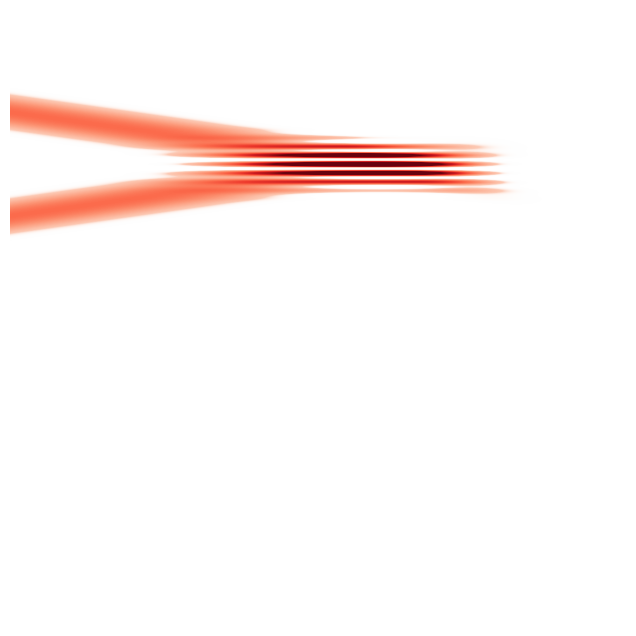

In [6]:
fig, axes = plt.subplots(ncols=1, nrows=1)
fig.set_figwidth(10)
fig.set_figheight(8)

# ------------------------------------------------------------
#   On the left, we have the pump pulse geometry
# ------------------------------------------------------------
ax1 = axes
# sample object
width = 150
height = 500
portion = 0.35
ang = sample_angle
sample = patches.Rectangle(xy=(- portion * height * np.cos(ang), - portion * height * np.sin(ang)),
                           width=width,
                           height=height,
                           angle=np.rad2deg(sample_angle) - 90,
                           rotation_point='xy',
                           color='goldenrod',
                           zorder=1)
#ax1.add_patch(sample)
"""
ax1.imshow(probe_intensity,
           alpha=probe_alpha,
           cmap='Greens',
           extent=[z_coor[0], z_coor[-1],
                   x_coor[-1], x_coor[0]],
           vmax=0.15,
           vmin=0,
           aspect=1,
           origin='upper', zorder=2)

ax1.imshow(diff_intensity,
           alpha=diff_alpha,
           cmap='Blues',
           extent=[z_coor[0], z_coor[-1],
                   x_coor[-1], x_coor[0]],
           vmax=0.6,
           vmin=0,
           aspect=1,
           origin='upper', zorder=2)

"""
ax1.imshow(pump_pulse_intensity,
           alpha=pump_pulse_alpha,
           cmap='Reds',
           extent=[z_coor[0], z_coor[-1],
                   x_coor[-1], x_coor[0]],
           aspect=1,
           vmax=2,
           vmin=0,
           origin='upper', zorder=2)
ax1.set_axis_off()

plt.savefig("./fig1_a_v1.png", transparent=True, dpi=300, bbox_inches='tight')

plt.show()
